### Learning Rate Annealing

On of the earliest methods we've noticed is that learning rate  is a factor that helps us to locate our global minimum.

We have three choice, high medium and low learning rates. These all have their advantages as well as disadvantages in trying to locate the global minimum. 

The major drawback to this method is that we use on learning rate throughout the training process. What if we wanted to be more dynamic in our approach?

What if we wanted to start with some learning rate, if we don't observe any improvement, we reduce the learning rate while training. 

In [1]:
from  torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from torch.optim import SGD, Adam
from torch import optim

In [2]:
data_folder = "~/data/FMNIST"
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_image = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        x = x.float()/255
        x = x.view(-1, 28*28) # flatten it to 784 numeric values
        self.x, self.y = x, y
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x, y
    def __len__(self):
        return len(self.x)

In [5]:
# Fetch the data
def get_data():
    train = MyDataset(tr_image, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = MyDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

# Define the model
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    return model, loss_fn, optimizer
    
# Define a function for training and validating the batch
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer = SGD(model.parameters(), lr=0.0001)
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()


def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.tolist()


In [6]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    loss_fn = nn.CrossEntropyLoss()
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [7]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [8]:
# create the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor= 0.5,
    patience=0,
    threshold=0.001,
    verbose=True,
    min_lr=1e-5,
    threshold_mode='abs'
)

/Users/macbookpro/Desktop/AI SIBERIA/Computer Vision /.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [9]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# let the training begin
for epoch in range(30):
    # print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.append(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        scheduler.step(validation_loss)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [10]:
len(train_losses)

30

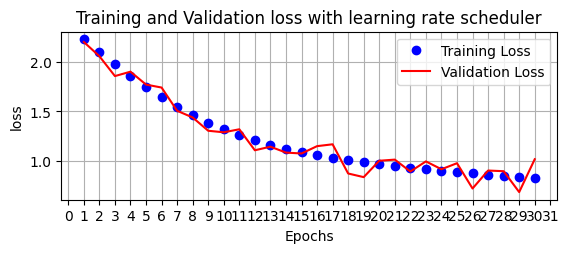

/var/folders/y5/5kc5fqvn2tncnl_868zg4zhr0000gn/T/ipykernel_9952/3663290159.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


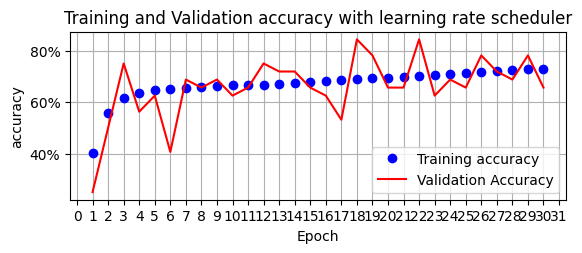

In [11]:
epochs = np.arange(30)+1
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label="Validation Loss")
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.legend()
plt.title("Training and Validation loss with learning rate scheduler")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label="Training accuracy")
plt.plot(epochs, val_accuracies, 'r', label="Validation Accuracy")
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title("Training and Validation accuracy with learning rate scheduler")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()
